In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import qutip as qt

from IPython.display import HTML

## Example: Atom-Cavity Interaction

### The Jaynes-Cummings Hamiltonian
If we want to put an atom *inside* of a cavity, all we have to do is make a term that takes a photon from the atom and gives it to the cavity and vice versa. This looks like $a^\dagger \sigma_-$ and $a \sigma_+$. Oure atom-cavity Hamiltonian is $H_{AF} = \hbar g \left( a^\dagger \sigma_- + a \sigma_+ \right)$.

$$
H = \hbar \omega_0 \left( \hat{n} + \frac{1}{2} \right) + \hbar \Omega \left( a^\dagger + a \right) + \hbar g \left( a^\dagger \sigma_- + a \sigma_+ \right)
$$

### The quantum state

In [3]:
# The initial state is a cavity with N=10 photons and an atom in the ground state
N = 10
psi0 = qt.tensor(qt.basis(2,0), qt.basis(N+1, N))

### Destruction and lowering operators

The $a$ operator destroys a photon. The $\sigma$ operator puts an atom in a lower state. 

In [4]:
# Identity operators don't do anything
id_atom = qt.qeye(2)  # two states
id_cav = qt.qeye(N+1)  # N + 1 states

# The photon-destruction operator: It doesn't change the atom, only the cavity
a = qt.tensor(id_atom, qt.destroy(N+1))

# The atom lowering operator: It doesn't change the cavity
sm = qt.tensor(qt.sigmam(), id_cav)

### Energy operators

The $n$ operator counts the number of photons and is proportional the field energy. The $\sigma_z$ operator is the dipole moment of the atom and is proportional to the atom energy. 

In [5]:
# The number operator counts the numbers of photons
n = qt.tensor(id_atom, qt.num(N+1))

# The sigma_z operator is the dipole moment of the atom
sz = qt.tensor(qt.sigmaz(), id_cav)

### The Hamiltonians

1. The energy of the photons
$$
H_{\text{field}} = \hbar \omega_0 \left( \hat{n} + \frac{1}{2} \right)
$$

2. We are adding and removing photons from the cavity at a rate $\Omega$.
$$
H_{\text{drive}} = \hbar \Omega \left( a^\dagger + a \right)
$$

3. At a rate of $g$, a photon from the cavity is absorbed or emitted by the atom
$$
H_{\text{coupling}} = \hbar g \left( a^\dagger \sigma + a\sigma^\dagger  \right)
$$

In [6]:
# Photon Hamiltonian
H_field = n + 1/2

# Drive Hamiltonian
Omega = 1
H_drive = Omega * (a + a.dag())

# Coupling Hamiltonian
g = 1
H_coupling = g * (a.dag() * sm + a * sm.dag())

# Total Hamiltonian 
H = H_field + H_drive + H_coupling

### The dissipation

We account for the fact that the system decays into the environment, we can include decay operators. In our case, the system leaks photons out of the cavity at a rate $\gamma$, so the collective operator is $\sqrt{\gamma} a$. 

In [7]:
gamma = 0.25
c_ops = [np.sqrt(gamma) * a]

### Initial state

We can initialize our state with the atom and cavity in the ground states. 

In [8]:
psi0 = qt.tensor(qt.basis(2,1), qt.basis(N+1, 0))

### Expectation values

Finally, we need to know what values of the system we want to monitor. Let's keep track of the number of photons $n$ and the dipole moment of the atom $\sigma_z$. 

In [9]:
exp_vals = [n, sm.dag()* sm]

### Simulation

When the dust settles, the atom is halfway excited and the cavity has two photons in it. Neat!

10.0%. Run time:   8.03s. Est. time left: 00:00:01:12
20.0%. Run time:   8.23s. Est. time left: 00:00:00:32
30.0%. Run time:   8.34s. Est. time left: 00:00:00:19
40.0%. Run time:   8.45s. Est. time left: 00:00:00:12
50.0%. Run time:   8.58s. Est. time left: 00:00:00:08
60.0%. Run time:   8.65s. Est. time left: 00:00:00:05
70.0%. Run time:   8.73s. Est. time left: 00:00:00:03
80.0%. Run time:   8.80s. Est. time left: 00:00:00:02
90.0%. Run time:   8.95s. Est. time left: 00:00:00:00
100.0%. Run time:   9.15s. Est. time left: 00:00:00:00
Total run time:   9.32s


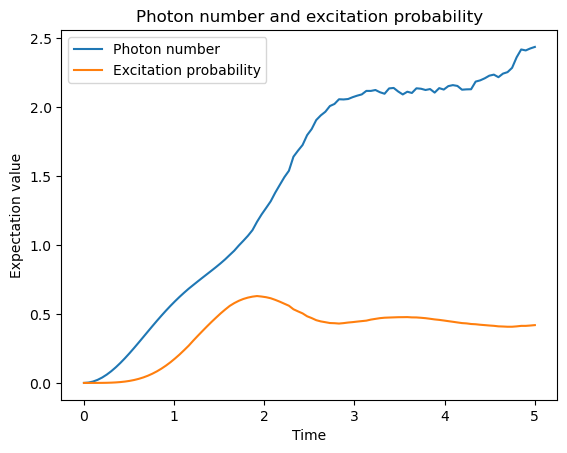

In [10]:
# Define the time vector
t = np.linspace(0, 5, 100)

# Solve with monte carlo
res = qt.mcsolve(H, psi0, t, c_ops, exp_vals, ntraj=100)

# Plot the results
fig, ax = plt.subplots()
ax.plot(t, res.expect[0], label='Photon number')
ax.plot(t, res.expect[1], label='Excitation probability')
ax.set_xlabel('Time')
ax.set_ylabel('Expectation value')
ax.set_title('Photon number and excitation probability')
ax.legend()


#### Visualize the electric field of the atom in the cavity

In [11]:
def visualize_atom(t, res):
    omega = 0.5

    cart2th = lambda x, y : np.arctan2(y, x)
    cart2r = lambda x, y : np.sqrt(x**2 + y**2)

    E_th = lambda r, theta, tau : np.sin(theta) * np.exp(1j * r - 1j * omega * tau) * (1/r**3 - 1j/r**2 - 1/r)
    E_r = lambda r, theta, tau : np.cos(theta) * np.exp(1j * r - 1j * omega * tau) * (2/r**3 - 2j/r**2)
    def E_tot(x,y, tau):
        r = cart2r(x,y)
        theta = cart2th(x,y)
        field = np.real(E_r(r, theta, tau) + E_r(r, theta, tau))
        field[r<2.] = np.sign(field[r<2.])
        return field.transpose()

    N = 100
    d = 15
    x = np.linspace(-d, d, N)
    y = np.linspace(-d, d ,N)
    X, Y = np.meshgrid(x, y)


    fig, ax = plt.subplots()
    cax = ax.imshow(E_tot(X,Y, 100), cmap='RdBu_r', animated=True)
    plt.close()

    def update(frame):
        cax.set_array(E_tot(X, Y, frame) * res.expect[0][frame])  # Update the phase based on the frame
        return cax,

    ani = FuncAnimation(fig, update, frames=len(t), blit=True, interval=1000/20)  # 20 fps

    return ani

animation = visualize_atom(t, res)
HTML(animation.to_jshtml())

# Appendix 

## Formalism of quantum optics 

The formalism of quantum optics is very intuitive. Everything is written in terms of matrices. The Hamiltonian $\hat{H}$ is matrix that acts as the *energy* operator. The Hamiltonian tells you about the time evolution of the system via the *Schr&ouml;dinger equation*. 

$$
\hat{H} \left| \psi \right> = -\frac{\partial}{\partial t} \left| \psi \right>
$$

Here, E is the energy. Note that $\hat{H}$ is a matrix, $\left| \psi \right>$ is a vector (actually, it's a ray, but they're pretty much the same), and $E$ is a number. The solution to this gives you a wavefunction $\left| \psi \right>$ with some time evolution and energy. 